# ISBI Cell Tracking Challenge 2015

We are going to segment the celltracking dataset: PhC-C2DH-U373  
Source: http://celltrackingchallenge.net/2d-datasets/  
Reference: Dr. S. Kumar. Department of Bioengineering, University of California at Berkeley, Berkeley CA (USA)

The cell tracking data set consist of 34 2D images in TIFF format.  
The images are glioblastoma-astrocytoma U373 cells on a polyacrylamide substrate.

## File structure setup

First we are going to setup our filestructure in order to use the Image IO Interface.  
What we want for the Image_interface is something like that:

```
data/
     imgname001/imaging.png
                segmentation.png
     imgname002/imaging.png
                segmentation.png
     imgname003/imaging.png
                segmentation.png
     ...
```

In [1]:
# Import some libraries
import os
import shutil
from PIL import Image
import numpy as np

# Configure data path for celltracking data set PhC-C2DH-U373 and file structure
path_dataset = "/home/mudomini/celltracking.MIScnn/PhC-C2DH-U373/"
path_filestructure = "/home/mudomini/celltracking.MIScnn/data"

In [2]:
# Initialize file structure
if not os.path.exists(path_filestructure): os.mkdir(path_filestructure)

# Iterate over both data sets
for ds in ["01", "02"]:
    # Define image directories
    path_ds_img = os.path.join(path_dataset, ds)
    path_ds_seg = os.path.join(path_dataset, ds + "_GT", "SEG")
    # Obtain sample list
    sample_list = os.listdir(path_ds_seg)
    # Remove every file which does not match image typ and preprocess sample names
    for i in reversed(range(0, len(sample_list))):
        if not sample_list[i].endswith(".tif"):
            del sample_list[i]
        else:
            sample_list[i] = sample_list[i][7:]
    # Iterate over each sample and transform the data into desired file structure
    for sample in sample_list:
        index = ds + "_" + sample[:-4]
        # Create sample directory
        path_sampleDir = os.path.join(path_filestructure, index)
        if not os.path.exists(path_sampleDir): os.mkdir(path_sampleDir)
        # Copy image file into filestructure
        path_ds_sample_img = os.path.join(path_ds_img, "t" + sample)
        path_fs_sample_img = os.path.join(path_sampleDir, "imaging.tif")
        shutil.copy(path_ds_sample_img, path_fs_sample_img)
        # Copy segmentation file into filestructure
        seg_file = "man_seg" + sample
        path_ds_sample_seg = os.path.join(path_ds_seg, seg_file)
        path_fs_sample_seg = os.path.join(path_sampleDir, "segmentation.tif")
        # Load segmentation from file
        seg_raw = Image.open(path_ds_sample_seg)
        # Convert segmentation from Pillow image to numpy matrix
        seg_pil = seg_raw.convert("LA")
        seg = np.array(seg_pil)
        # Keep only intensity and remove maximum intensitiy range
        seg_data = seg[:,:,0]
        # Union all separate cell classes to a single one
        seg_data[seg_data > 0] = 1
        # Transform numpy array back to a Pillow image & save to disk
        seg = Image.fromarray(seg_data)
        seg.save(path_fs_sample_seg, format="TIFF")

## Data exploration

Before we start building our medical image segmentation pipeline, let's have a look on our data by visualizing one.

Due to the images are now in the correct file structure, we can utilize the MIScnn data loader and Image IO interface.  
We are starting by initializing the MIScnn data loader.

In [3]:
# Tensorflow Configuration for GPU Cluster (not required if you are training on your own GPU)
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

In [4]:
# Import some libraries
from miscnn import Data_IO
from miscnn.data_loading.interfaces import Image_interface

# Initialize Data IO & Image Interface
interface = Image_interface(classes=2, img_type="grayscale", img_format="tif")
data_path = "/home/mudomini/celltracking.MIScnn/data/"
data_io = Data_IO(interface, data_path, delete_batchDir=True)

# Obtain the sample list
sample_list = data_io.get_indiceslist()
sample_list.sort()

Now wer are going to use the MIScnn data loader and visualize the images via Pillow.

Shape of image: (520, 696, 1)


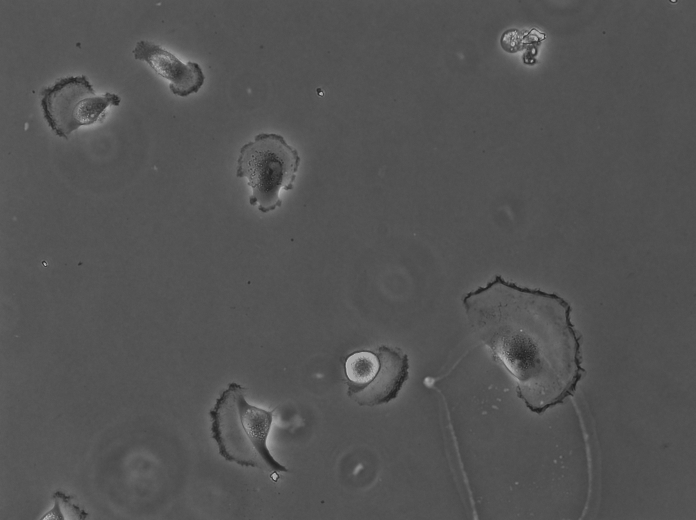

Shape of segmentation: (520, 696, 1)


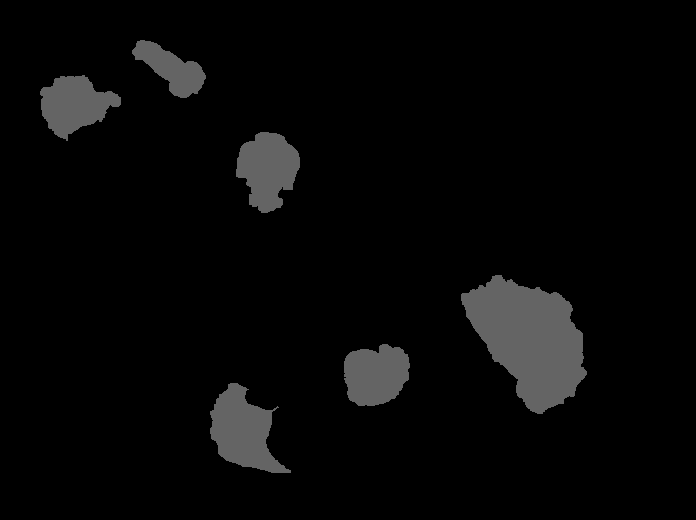

In [5]:
from IPython.display import display

# Load the first sample via MIScnn data loader
sample_test = data_io.sample_loader(sample_list[0], load_seg=True)

# Visualize the image
img_data = sample_test.img_data
print("Shape of image:", img_data.shape)
img = Image.fromarray(np.reshape(img_data, img_data.shape[:-1]))
display(img)

# Visualize the ground truth segmentation
seg_data = sample_test.seg_data * 100
print("Shape of segmentation:", seg_data.shape)
seg = Image.fromarray(np.reshape(seg_data, seg_data.shape[:-1]))
display(seg)

## MIScnn pipeline

Now, we can start setup our MIScnn pipeline.  
In this scenario, we just want to perform a training and prediction process.

Even though we already initialized the MIScnn data loader, we are still doing it again in order to have a complete copy&paste section with the complete code for setting up MIScnn.

In [6]:
# Import some libraries
from miscnn import Data_IO, Preprocessor, Neural_Network
from miscnn.data_loading.interfaces import Image_interface
from miscnn.neural_network.metrics import tversky_crossentropy, dice_soft, \
                                          dice_crossentropy, tversky_loss
from miscnn.processing.subfunctions import Resize, Normalization

# Initialize Data IO & Image Interface
interface = Image_interface(classes=2, img_type="grayscale", img_format="tif")
data_path = "/home/mudomini/celltracking.MIScnn/data/"
data_io = Data_IO(interface, data_path, delete_batchDir=True)

# Obtain the sample list
sample_list = data_io.get_indiceslist()
sample_list.sort()

# Create a pixel value normalization Subfunction for z-score scaling
sf_zscore = Normalization(mode="z-score")
# Create a resizing Subfunction to shape 592x592
sf_resize = Resize((592, 592))

# Assemble Subfunction classes into a list
sf = [sf_resize]

# Initialize Preprocessor
pp = Preprocessor(data_io, batch_size=2, subfunctions=sf,
                  prepare_subfunctions=True, prepare_batches=False,
                  analysis="fullimage")

 # Create the Neural Network model
model = Neural_Network(preprocessor=pp, loss=tversky_crossentropy,
                       metrics=[tversky_loss, dice_soft, dice_crossentropy],
                       batch_queue_size=3, workers=5, learninig_rate=0.001)

This is it. Now, we have our model which we can use to perform the training process.

Additionally, we use a few Keras Callbacks in order to increase the performance as well as to allow monitoring the training process.

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard

# Define Callbacks
cb_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5,
                          verbose=1, mode='min', min_delta=0.0001, cooldown=1,
                          min_lr=0.00001)
cb_tb = TensorBoard(log_dir="tensorboard", histogram_freq=0, write_graph=True, 
                    write_images=True)

model.train(sample_list[1:], epochs=100, iterations=50, callbacks=[cb_lr, cb_tb])

Epoch 1/100
50/50 [==============================] - 57s 1s/step - loss: 1.1690 - tversky_loss: 0.7802 - dice_soft: 0.6069 - dice_crossentropy: 0.7907 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 7s 145ms/step - loss: 0.6683 - tversky_loss: 0.4818 - dice_soft: 0.7571 - dice_crossentropy: 0.4307 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 8s 151ms/step - loss: 0.3757 - tversky_loss: 0.2532 - dice_soft: 0.8737 - dice_crossentropy: 0.2446 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 7s 146ms/step - loss: 0.2769 - tversky_loss: 0.1776 - dice_soft: 0.9124 - dice_crossentropy: 0.1868 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 7s 141ms/step - loss: 0.2305 - tversky_loss: 0.1497 - dice_soft: 0.9252 - dice_crossentropy: 0.1527 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 7s 149ms/step - loss: 0.2594 - tversky_loss: 0.1645 - dice_soft: 0.9143 - dice_crossentropy: 0.1810 - lr: 0.0010
Epoch 

We can congratulate us, because we successfully trained our model for cell segmentation.

Now let's use this new model to predict an unknown image -> the first sample in our list.

In [8]:
model.predict(sample_list[0:1])

We have successfully predicted the cell segmentation of the first sample.

Now, let's have a look on the predicted segmentation in comparison with the ground truth segmentation.

Shape of segmentation: (520, 696, 1)


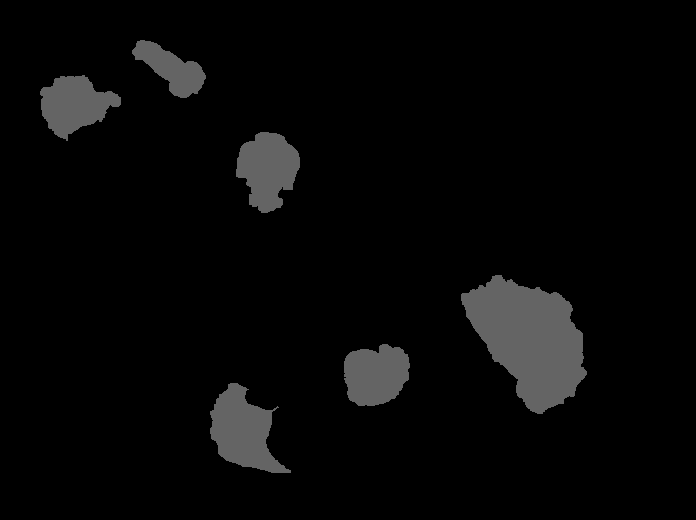

Shape of prediction: (520, 696, 1)


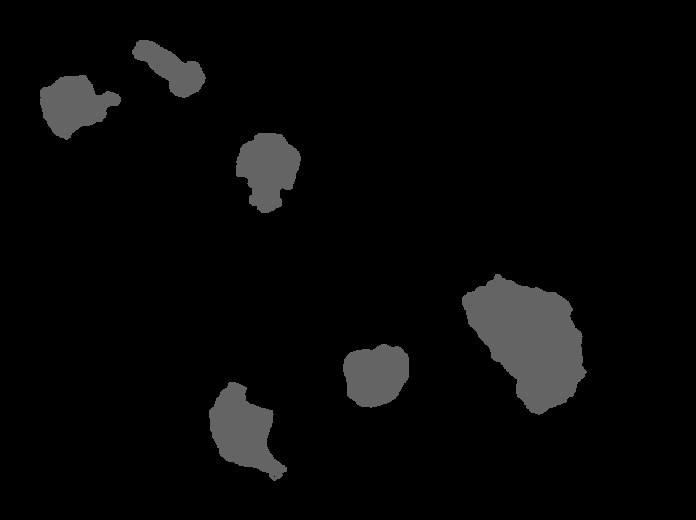

In [9]:
from IPython.display import display

# Load the first sample via MIScnn data loader
sample_test = data_io.sample_loader(sample_list[0], load_seg=True, load_pred=True)

# Visualize the ground truth segmentation
seg_data = sample_test.seg_data * 100
print("Shape of segmentation:", seg_data.shape)
seg = Image.fromarray(np.reshape(seg_data, seg_data.shape[:-1]))
display(seg)

# Visualize the predicted segmentation
pred_data = sample_test.pred_data * 100
print("Shape of prediction:", pred_data.shape)
pred = Image.fromarray(np.reshape(pred_data, pred_data.shape[:-1]))
display(pred)

Let's compute the dice similarity coefficient to measure the overlap between segmentation and prediction.

In [10]:
def calc_DSC(truth, pred, classes):
    dice_scores = []
    # Iterate over each class
    for i in range(classes):
        try:
            gt = np.equal(truth, i)
            pd = np.equal(pred, i)
            # Calculate Dice
            dice = 2*np.logical_and(pd, gt).sum() / (pd.sum() + gt.sum())
            dice_scores.append(dice)
        except ZeroDivisionError:
            dice_scores.append(0.0)
    # Return computed Dice Similarity Coefficients
    return dice_scores

In [11]:
dsc = calc_DSC(sample_test.seg_data, sample_test.pred_data, classes=2)
print("DSC for Segmentation:", dsc[1])

DSC for Segmentation: 0.9785139434774471


## Final words

Here, I presented the workflow of using MIScnn for biomedical image segmentation problems like in this example: ISBI Cell Tracking Challenge 2015.  
I hope to give you an intention on how MIScnn works and how you can integrate/use MIScnn in your research projects.

For further questions or suggestions, please do not hesitate to get in contact with me.  
Also, if you want to contribute to MIScnn do not hesitate! :)

Thanks for reading,  
Dominik Müller